In [100]:
'''
Krishna Somandepalli - Oct 2020
Error analysis utilities for multilabel cases.
'''

%matplotlib inline
%pylab inline
import itertools
import numpy as np
from sklearn.metrics import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import seaborn as sn

Populating the interactive namespace from numpy and matplotlib


In [101]:
LABELS = ['action',  'adventure', 'advertising',  'background',  'ballad',  'calm',  'children',
 'christmas',  'commercial',  'cool',  'corporate',  'dark',  'deep',  'documentary',  'drama',
 'dramatic',  'dream',  'emotional',  'energetic',  'epic',  'fast',  'film',  'fun',  'funny',
 'game',  'groovy',  'happy',  'heavy',  'holiday',  'hopeful',  'inspiring',  'love',  'meditative',
 'melancholic',  'melodic',  'motivational',  'movie',  'nature',  'party',  'positive',  'powerful',
 'relaxing', 'retro',  'romantic',  'sad',  'sexy',  'slow',  'soft',  'soundscape',  'space',  'sport',
 'summer',  'trailer',  'travel',  'upbeat',  'uplifting'] 

In [102]:
# Load validation and test gt from 'best' model
val_gt = np.load('best_model_performance/val_ground_truth.npy')
val_pred = np.load('best_model_performance/val_predictions.npy')
test_gt = np.load('best_model_performance/test_ground_truth.npy')
test_pred = np.load('best_model_performance/test_predictions.npy')

In [103]:
# convert predicted posteriors to top-1 and top-3 labels
# input is Nxm : N data samples m labels/classes
def get_topx_inference(pred_arr, top_x=1):
    pred_at_topx = pred_arr.copy()
    for n in range(pred_arr.shape[0]):
        pred_n = pred_arr[n]
        pred_at_topx[n][
            np.argsort(pred_n)[-top_x:].tolist()
        ] = 1
    pred_at_topx[pred_at_topx!=1] = 0
    return pred_at_topx   

In [104]:
# confusion matrix (CM) for a multilabel case - @top X fashion
# Note: For variable multilabel case with different number of labels per sample, 
# CM at top 1 is often an underestimate of performance
def multilabel_confusion_matrix(gt, pred, top_x=1):
    num_samples, num_labels = gt.shape 
    cm = np.zeros((num_labels, num_labels))
    pred_at_top_x = get_topx_inference(pred, top_x)
    for i in range(num_samples):
        where_gt = np.where(gt[i])[0].tolist()
        where_pred = np.where(pred_at_top_x[i])[0].tolist()
        gt_v_pred = list(itertools.product(where_gt, where_pred))
        for m,n in gt_v_pred: cm[m,n]+=1
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm     

# How to estimate the "true" confusion matrix?
# assume the number of labels per sample is given and do variable inference - this is upper bound perf.
def multilabel_confusion_matrix_est(gt, pred):
    num_samples, num_labels = gt.shape 
    cm = np.zeros((num_labels, num_labels))
    for i in range(num_samples):
        where_gt = np.where(gt[i])[0].tolist()
        where_pred = np.argsort(pred[i])[-len(where_gt):].tolist()
        gt_v_pred = list(itertools.product(where_gt, where_pred))
        for m,n in gt_v_pred: cm[m,n]+=1
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm     


### Describe following metrics:
1. Label distributions
2. Label co-occurances
3. Per class average-precision (AP) and mean AP (mAP)
4. Confusion matrix @Top1 and @Top3

#### 1. Label Dist.

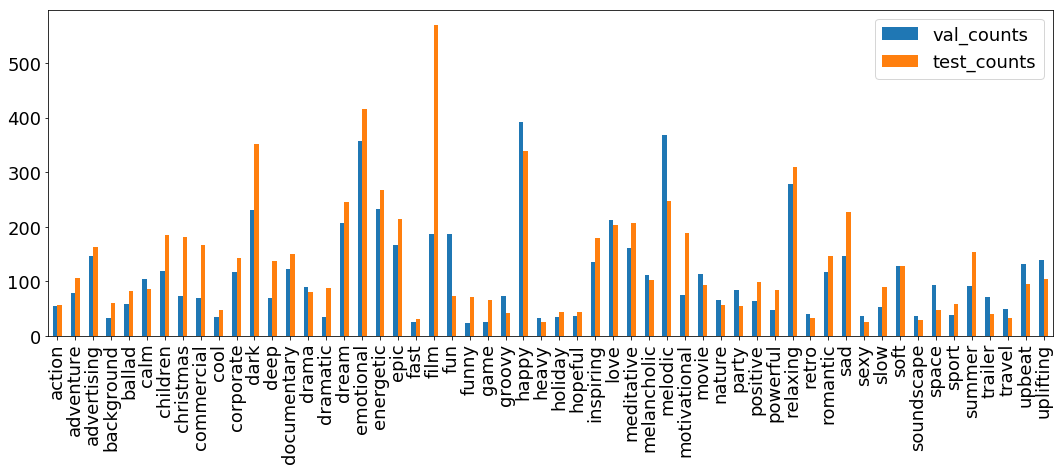

In [105]:
# Describe label distributions of validation and test sets
pylab.rcParams['figure.figsize'] = (18, 6)
df1 = pd.DataFrame(index=LABELS)
df1['val_counts'] = np.count_nonzero(val_gt,0).tolist()
df1['test_counts'] = np.count_nonzero(test_gt,0).tolist()
ax = df1.plot.bar()

#### 2. Label Co-occurrance

In [106]:
val_gt_df = pd.DataFrame(data = val_gt.astype('int'), columns=LABELS)
test_gt_df = pd.DataFrame(data = test_gt.astype('int'), columns=LABELS)
val_coocc = val_gt_df.T.dot(val_gt_df)
test_coocc = test_gt_df.T.dot(test_gt_df)
np.fill_diagonal(val_coocc.values, 0)
np.fill_diagonal(test_coocc.values, 0)

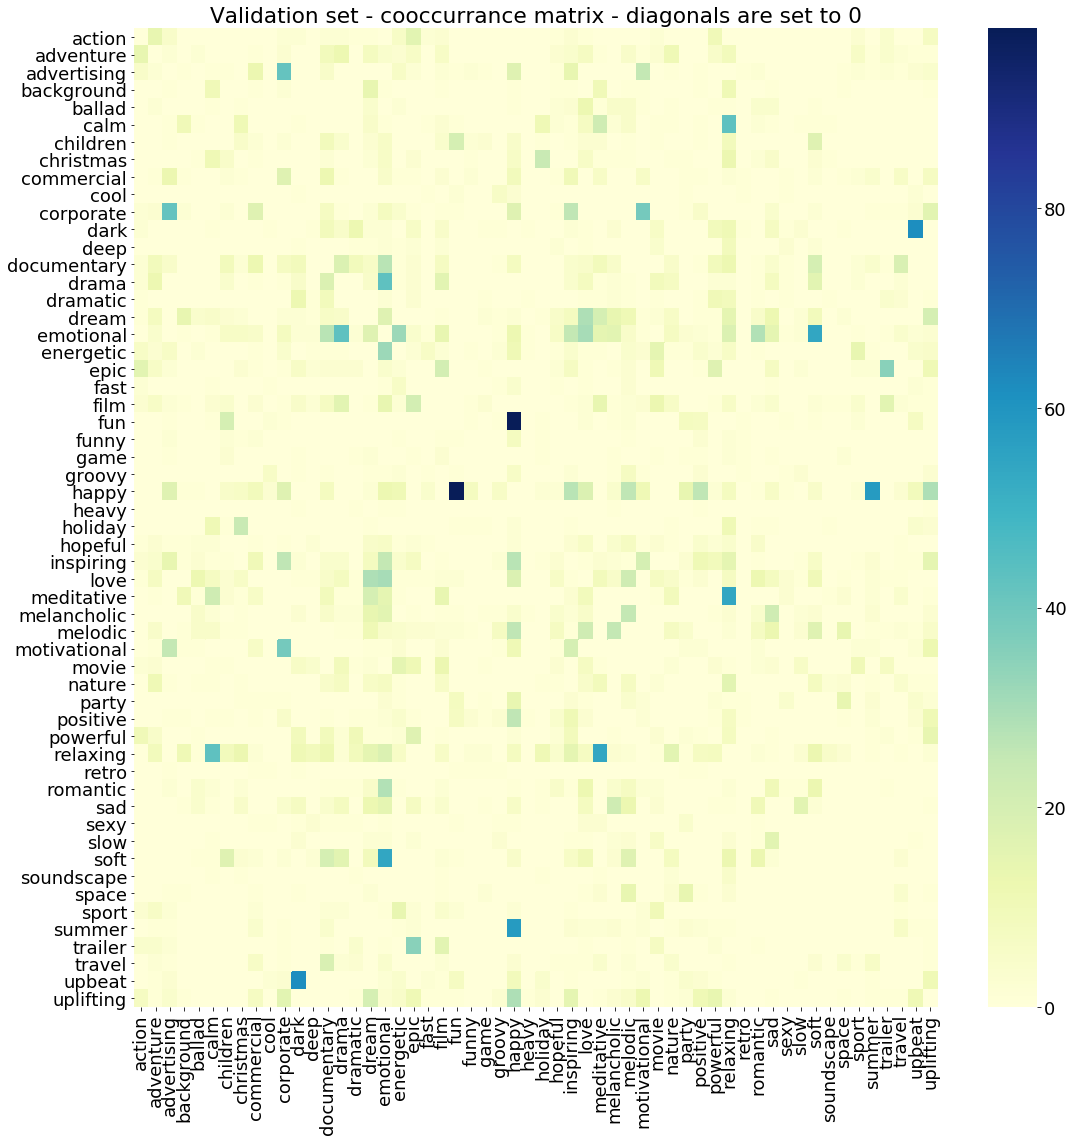

In [107]:
pylab.rcParams['figure.figsize'] = (18, 18);
sn.heatmap(val_coocc, cmap="YlGnBu", xticklabels=True, yticklabels=True);
plt.title('Validation set - cooccurrance matrix - diagonals are set to 0');

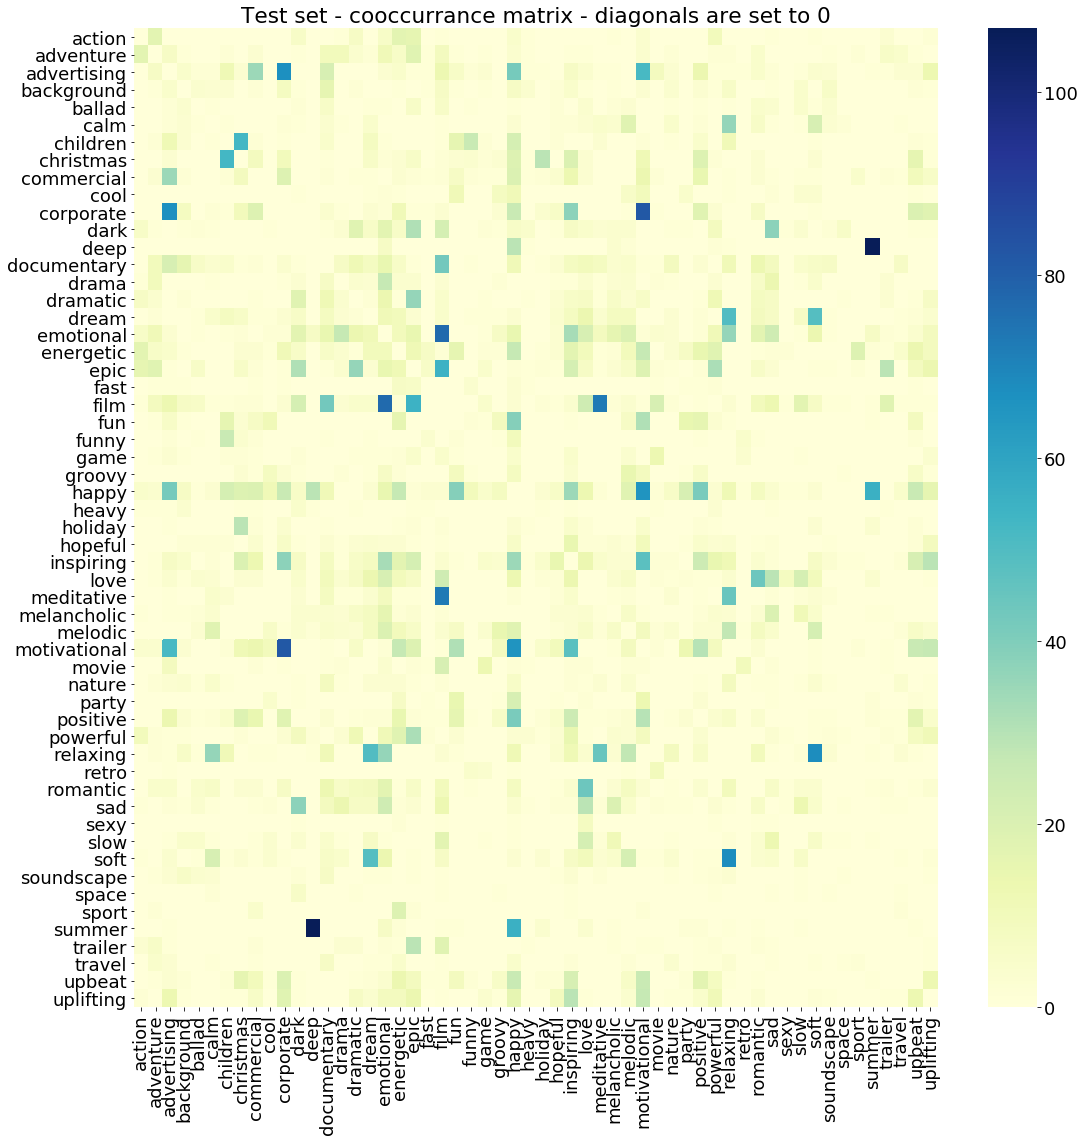

In [108]:
pylab.rcParams['figure.figsize'] = (18, 18);
sn.heatmap(test_coocc, cmap="YlGnBu", xticklabels=True, yticklabels=True);
plt.title('Test set - cooccurrance matrix - diagonals are set to 0');

#### 3. Average precision  - per class and mean

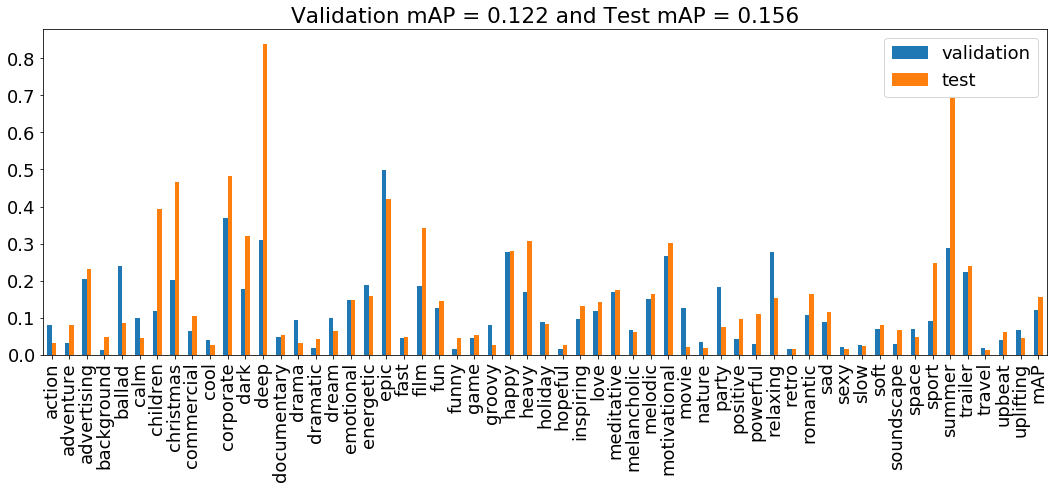

In [109]:
pylab.rcParams['figure.figsize'] = (18, 6)
val_ap = []
test_ap = []
for i in range(len(LABELS)):
    val_ap.append(average_precision_score(val_gt[:,i], val_pred[:,i]))
    test_ap.append(average_precision_score(test_gt[:,i], test_pred[:,i]))
# append mean AP
val_ap.append(np.mean(val_ap))
test_ap.append(np.mean(test_ap))
df2 = pd.DataFrame(index=LABELS + ['mAP'])
df2['validation'] = val_ap
df2['test'] = test_ap
ax = df2.plot.bar()
plt.title('Validation mAP = %.3f and Test mAP = %.3f' % (val_ap[-1], test_ap[-1]));

In [110]:
#printing AP values
df2

,validation,test
action,0.080503,0.031381
adventure,0.033023,0.081014
advertising,0.205727,0.230920
background,0.012249,0.048165
ballad,0.239657,0.087339
calm,0.100141,0.045758
children,0.117527,0.394021
christmas,0.203157,0.464939
commercial,0.064525,0.105781
cool,0.040898,0.027055


#### 4. *Normalized* Confusion Matrices

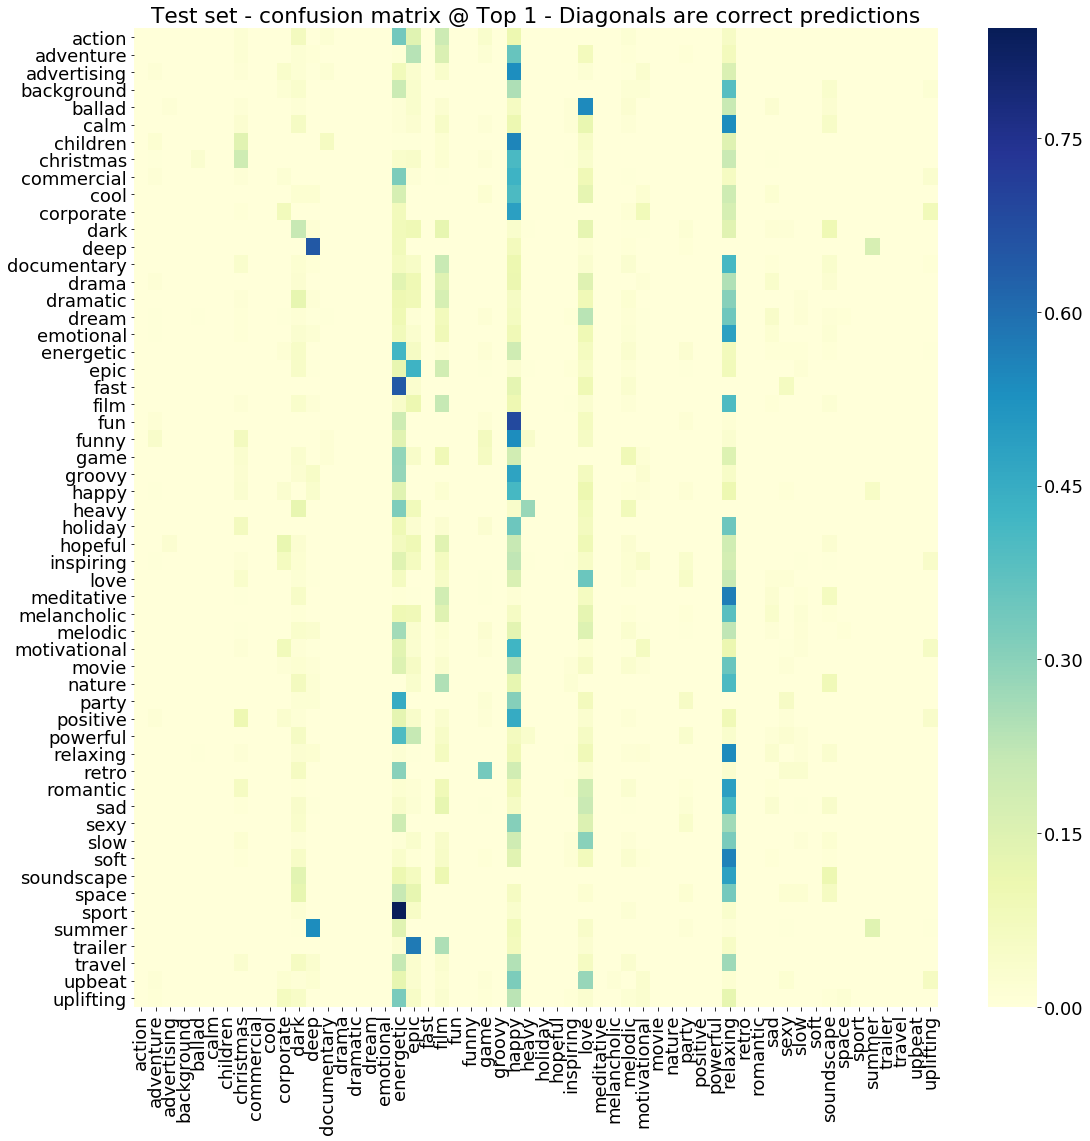

In [111]:
pylab.rcParams['figure.figsize'] = (18, 18);
test_cm_at_top1 = multilabel_confusion_matrix(test_gt, test_pred)
df_cm1 = pd.DataFrame(data=test_cm_at_top1, columns=LABELS, index=LABELS)
sn.heatmap(df_cm1, cmap="YlGnBu", xticklabels=True, yticklabels=True);
plt.title('Test set - confusion matrix @ Top 1 - Diagonals are correct predictions');

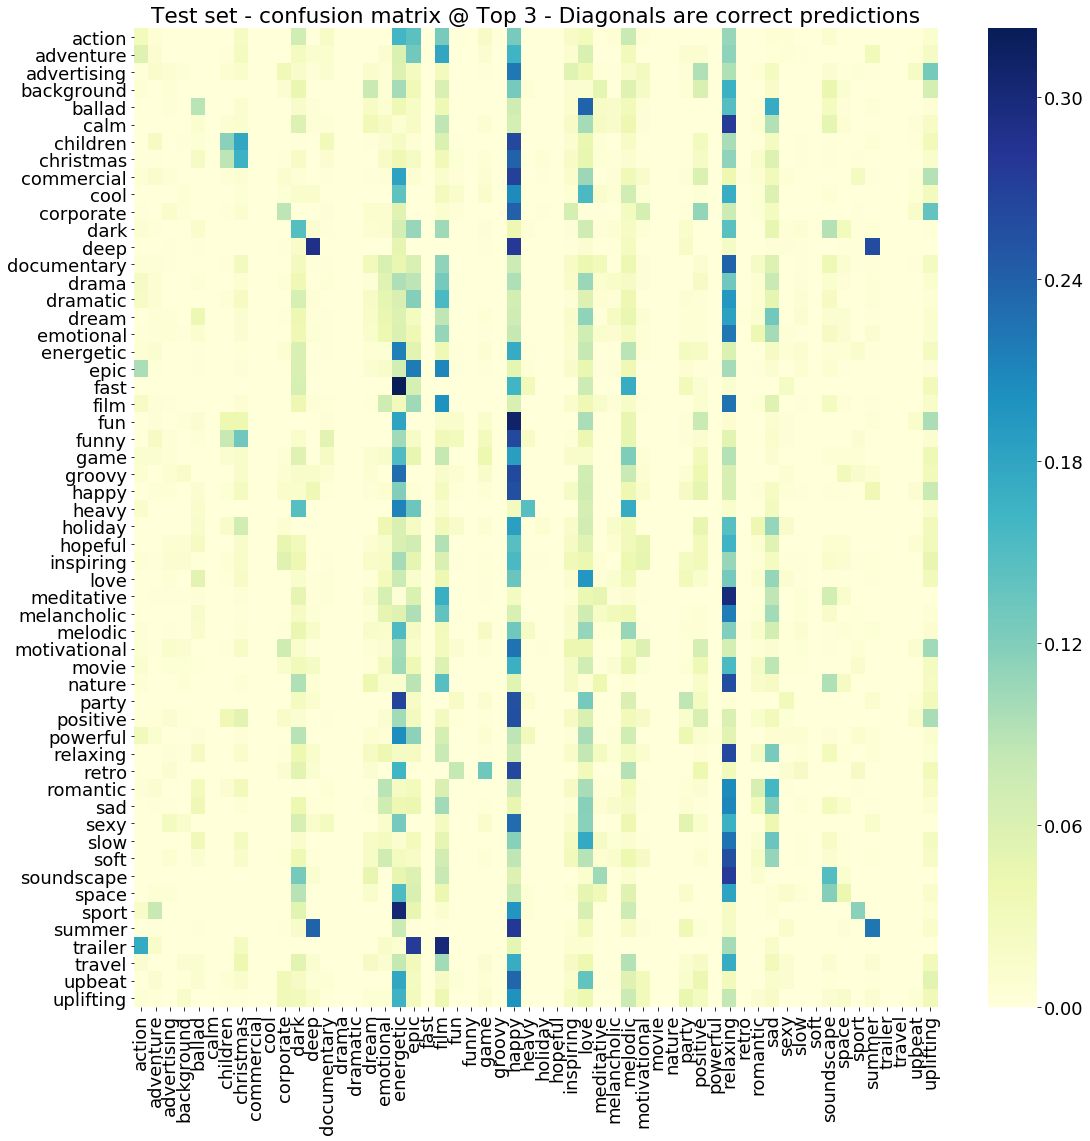

In [112]:
pylab.rcParams['figure.figsize'] = (18, 18);
test_cm_at_top3 = multilabel_confusion_matrix(test_gt, test_pred, top_x=3)
df_cm3 = pd.DataFrame(data=test_cm_at_top3, columns=LABELS, index=LABELS)
sn.heatmap(df_cm3, cmap="YlGnBu", xticklabels=True, yticklabels=True);
plt.title('Test set - confusion matrix @ Top 3 - Diagonals are correct predictions');

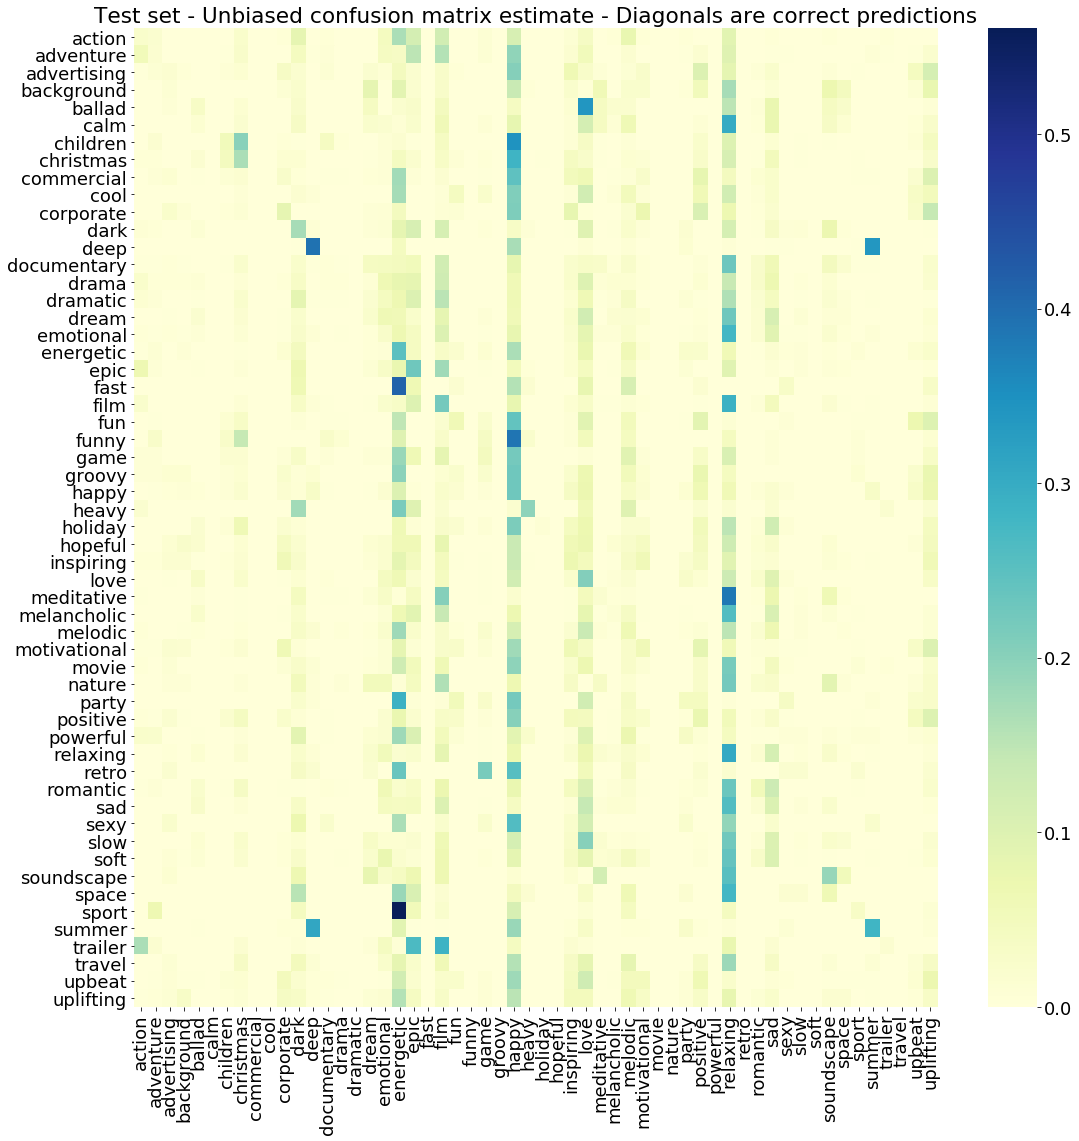

In [113]:
pylab.rcParams['figure.figsize'] = (18, 18);
test_cm_at_top1 = multilabel_confusion_matrix_est(test_gt, test_pred)
df_cm1 = pd.DataFrame(data=test_cm_at_top1, columns=LABELS, index=LABELS)
sn.heatmap(df_cm1, cmap="YlGnBu", xticklabels=True, yticklabels=True);
plt.title('Test set - Unbiased confusion matrix estimate - Diagonals are correct predictions');